#2 dsfaisdf

In [110]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

from gtfparse import read_gtf

import os
import gzip
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold

In [2]:
df_genesymbols = pd.read_excel("41586_2011_BFnature10350_MOESM321_ESM.xls", sheet_name = 'All metabolic genes', usecols='B:B')

# returns GTF with essential columns such as "feature", "seqname", "start", "end"
# alongside the names of any optional keys which appeared in the attribute column
df = read_gtf("gencode_annotation.gtf")

# filter DataFrame to gene entries on chrY
df_genes = df[df["feature"] == "gene"]
df_genes_chrY = df_genes[df_genes["seqname"] == "Y"]

C:\Users\TTTTTT\anaconda3\envs\uzop2\lib\site-packages\gtfparse\read_gtf.py:151: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  result = parse_gtf(
C:\Users\TTTTTT\anaconda3\envs\uzop2\lib\site-packages\gtfparse\read_gtf.py:151: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  result = parse_gtf(
INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_status', 'gene_name', 'level', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_status', 'transcript_name', 'tag', 'transcript_support_level', 'havana_transcript', 'exon_number', 'exon_id', 'ont', 'protein_id', 'ccdsid']


In [3]:
print(df_genesymbols)


df_genes["len"] = df_genes["end"] - df_genes["start"]

df_genes2 = df_genes[["gene_id", "gene_name", "len"]]
#print(df_genes)
print(df_genes2)

     Gene Symbol
0          ABCA1
1         ABCA10
2         ABCA12
3         ABCA13
4          ABCA2
...          ...
2747        PDXP
2748    PHOSPHO2
2749        PNPO
2750        DCXR
2751        XYLB

[2752 rows x 1 columns]
                   gene_id     gene_name    len
0        ENSG00000223972.5       DDX11L1   2540
12       ENSG00000227232.5        WASH7P  15166
25       ENSG00000278267.1     MIR6859-3     67
28       ENSG00000243485.3  RP11-34P13.3   1555
36       ENSG00000274890.1     MIR1302-9    137
...                    ...           ...    ...
2563652  ENSG00000198695.2        MT-ND6    524
2563657  ENSG00000210194.1         MT-TE     68
2563660  ENSG00000198727.2        MT-CYB   1140
2563665  ENSG00000210195.2         MT-TT     65
2563668  ENSG00000210196.2         MT-TP     67

[60483 rows x 3 columns]


In [65]:
path = './TCGA_data'

patients = [[] for x in range(60482)]

num = 0
list_of_patients = []
# Adding gene_id to start of a list
for dirpath, dirnames, files in os.walk(path):
    if num != 0:
        break
    for file_name in files:
        num = 1
        list_of_patients.append(file_name)
        try:
            with gzip.open(dirpath + '\\' + file_name, 'rb') as f:
                data = f.readlines()
                for count, i in enumerate(data[:-4]):
                    patients[count].append(i.decode('ascii').strip().split('\t')[0])
        except:
            continue
# Adding numbers to each gene_id
for dirpath, dirnames, files in os.walk(path):
    for file_name in files:
        try:
            with gzip.open(dirpath + '\\' + file_name, 'rb') as f:
                data = f.readlines()
                for count, i in enumerate(data[:-4]):
                    patients[count].append(float(i.decode('ascii').strip().split('\t')[1]))

        except:
            continue

In [66]:
print(len(patients))

60482


In [28]:

df_patients = pd.DataFrame(patients)

print(df_patients)

                      0       1       2       3       4       5       6    \
0      ENSG00000000003.13  3737.0  2984.0  4410.0  2066.0  5510.0  7788.0   
1       ENSG00000000005.5    12.0     0.0     0.0     3.0    25.0     1.0   
2      ENSG00000000419.11  1200.0  1336.0  1034.0  2247.0  1761.0   929.0   
3      ENSG00000000457.12   326.0   565.0   509.0   305.0  1375.0   334.0   
4      ENSG00000000460.15    50.0   550.0   156.0   279.0   747.0   266.0   
...                   ...     ...     ...     ...     ...     ...     ...   
60477   ENSGR0000270726.4     0.0     0.0     0.0     0.0     0.0     0.0   
60478   ENSGR0000275287.3     0.0     0.0     0.0     0.0     0.0     0.0   
60479   ENSGR0000276543.3     0.0     0.0     0.0     0.0     0.0     0.0   
60480   ENSGR0000277120.3     0.0     0.0     0.0     0.0     0.0     0.0   
60481   ENSGR0000280767.1     0.0     0.0     0.0     0.0     0.0     0.0   

          7       8       9    ...     415     416     417     418     419 

In [29]:
df_metabolic = pd.merge(left = df_genesymbols, right = df_genes2, how = 'left', left_on = 'Gene Symbol', right_on = 'gene_name')[['gene_id', 'gene_name', 'len']]

print(df_metabolic)

                 gene_id gene_name       len
0     ENSG00000165029.14     ABCA1  147235.0
1     ENSG00000154263.16    ABCA10   97632.0
2     ENSG00000144452.13    ABCA12  206886.0
3     ENSG00000179869.13    ABCA13  476038.0
4     ENSG00000107331.15     ABCA2   21695.0
...                  ...       ...       ...
2763   ENSG00000241360.1      PDXP    8207.0
2764  ENSG00000144362.10  PHOSPHO2    7254.0
2765   ENSG00000108439.8      PNPO    6782.0
2766   ENSG00000169738.6      DCXR    2596.0
2767   ENSG00000093217.8      XYLB   74588.0

[2768 rows x 3 columns]


In [40]:
df_patients_met = pd.merge(left = df_metabolic, right = df_patients, how = 'left', left_on = 'gene_id', right_on = 0).drop(columns = [0])

print(df_patients_met)

                 gene_id gene_name       len        1       2        3  \
0     ENSG00000165029.14     ABCA1  147235.0   1138.0  4252.0   2850.0   
1     ENSG00000154263.16    ABCA10   97632.0     69.0   447.0    105.0   
2     ENSG00000144452.13    ABCA12  206886.0      4.0    10.0     12.0   
3     ENSG00000179869.13    ABCA13  476038.0     19.0    12.0     67.0   
4     ENSG00000107331.15     ABCA2   21695.0    889.0  4689.0   1806.0   
...                  ...       ...       ...      ...     ...      ...   
2763   ENSG00000241360.1      PDXP    8207.0     81.0    94.0    137.0   
2764  ENSG00000144362.10  PHOSPHO2    7254.0     53.0    85.0     56.0   
2765   ENSG00000108439.8      PNPO    6782.0   2344.0   570.0   2454.0   
2766   ENSG00000169738.6      DCXR    2596.0  17778.0  6790.0  18319.0   
2767   ENSG00000093217.8      XYLB   74588.0    848.0  1575.0   1053.0   

            4         5        6        7  ...      415      416      417  \
0      2561.0    4945.0   1338.0  

In [41]:
#RPK
df_patients_met.iloc[:,3:] = df_patients_met.iloc[:,3:].div(df_patients_met.len/1000, axis=0)

#TPM
for i, column in enumerate(df_patients_met):
    if i < 3:
        continue
    df_patients_met[column] = df_patients_met[column] / (df_patients_met[column].sum()/1000000)

print(df_patients_met)

                 gene_id gene_name       len            1           2  \
0     ENSG00000165029.14     ABCA1  147235.0     2.765525    8.140151   
1     ENSG00000154263.16    ABCA10   97632.0     0.252874    1.290522   
2     ENSG00000144452.13    ABCA12  206886.0     0.006918    0.013624   
3     ENSG00000179869.13    ABCA13  476038.0     0.014281    0.007105   
4     ENSG00000107331.15     ABCA2   21695.0    14.661842   60.921532   
...                  ...       ...       ...          ...         ...   
2763   ENSG00000241360.1      PDXP    8207.0     3.531401    3.228447   
2764  ENSG00000144362.10  PHOSPHO2    7254.0     2.614236    3.302871   
2765   ENSG00000108439.8      PNPO    6782.0   123.664844   23.690123   
2766   ENSG00000169738.6      DCXR    2596.0  2450.330377  737.250926   
2767   ENSG00000093217.8      XYLB   74588.0     4.067929    5.951985   

                3            4            5             6            7  ...  \
0        8.450633     5.907284     6.656366 

In [62]:
mad = stats.median_abs_deviation(x = df_patients_met.iloc[:, 3:], axis = 1)

df_mad_analysis = df_patients_met.copy()
to_drop = []
for i, n in enumerate(mad):
    if n <= 0.5:
        to_drop.append(i)
df_mad_analysis = df_mad_analysis.drop(to_drop)
print(df_mad_analysis)

[3.87623252e+00 2.32878340e-01 4.81285631e-03 ... 7.03404900e+01
 2.23476607e+03 3.83611437e+00]
833
                 gene_id gene_name       len            1           2  \
0     ENSG00000165029.14     ABCA1  147235.0     2.765525    8.140151   
4     ENSG00000107331.15     ABCA2   21695.0    14.661842   60.921532   
5     ENSG00000167972.12     ABCA3   64865.0     0.899132    0.317222   
7     ENSG00000154265.14     ABCA5   82933.0     4.241042    6.175581   
8     ENSG00000154262.11     ABCA6   63186.0    11.925701    5.558370   
...                  ...       ...       ...          ...         ...   
2763   ENSG00000241360.1      PDXP    8207.0     3.531401    3.228447   
2764  ENSG00000144362.10  PHOSPHO2    7254.0     2.614236    3.302871   
2765   ENSG00000108439.8      PNPO    6782.0   123.664844   23.690123   
2766   ENSG00000169738.6      DCXR    2596.0  2450.330377  737.250926   
2767   ENSG00000093217.8      XYLB   74588.0     4.067929    5.951985   

                3     

In [74]:
df_clinical_tcga = pd.read_csv('./TCGA_clinical/clinical.tsv', sep='\t', header=0)


In [75]:
df_clinical_tcga = df_clinical_tcga.drop_duplicates(subset=['case_id'])
print(df_clinical_tcga.sort_values(by=['case_id']))

#cox analiza nije odrađena jer nema donor_survival_time metrike

                                  case_id case_submitter_id project_id  \
142  0004d251-3f70-4395-b175-c94c2f5b1b81      TCGA-DD-AAVP  TCGA-LIHC   
264  001887aa-36d0-463f-8bca-dec7043b4f2e      TCGA-DD-A4NP  TCGA-LIHC   
646  00f209c3-041a-4c6e-8b0f-6383eb3c85fc      TCGA-BC-4073  TCGA-LIHC   
320  010d5817-9a3f-4a06-8643-653116c044ff      TCGA-MI-A75E  TCGA-LIHC   
140  01cc571c-a47c-4548-9c14-5e51c79b095b      TCGA-G3-A7M8  TCGA-LIHC   
..                                    ...               ...        ...   
344  f6e5979d-d6a9-4408-bd1b-1b37d1064e83      TCGA-G3-A25T  TCGA-LIHC   
324  f82aff25-0725-48d1-aefd-d60800f7d1ab      TCGA-UB-A7MC  TCGA-LIHC   
54   fb2abc2a-ecf1-4184-912f-26a649f861ff      TCGA-GJ-A3OU  TCGA-LIHC   
552  fbb0e4bc-5398-4a7e-963c-86ea1108a2de      TCGA-DD-AAEH  TCGA-LIHC   
554  fbb398fe-2ba8-4845-8083-6533ecb4a52e      TCGA-KR-A7K2  TCGA-LIHC   

    age_at_index age_is_obfuscated cause_of_death cause_of_death_source  \
142           48               '--  

'The column headers :'

['case_id',
 'case_submitter_id',
 'project_id',
 'age_at_index',
 'age_is_obfuscated',
 'cause_of_death',
 'cause_of_death_source',
 'country_of_residence_at_enrollment',
 'days_to_birth',
 'days_to_death',
 'ethnicity',
 'gender',
 'occupation_duration_years',
 'premature_at_birth',
 'race',
 'vital_status',
 'weeks_gestation_at_birth',
 'year_of_birth',
 'year_of_death',
 'age_at_diagnosis',
 'ajcc_clinical_m',
 'ajcc_clinical_n',
 'ajcc_clinical_stage',
 'ajcc_clinical_t',
 'ajcc_pathologic_m',
 'ajcc_pathologic_n',
 'ajcc_pathologic_stage',
 'ajcc_pathologic_t',
 'ajcc_staging_system_edition',
 'anaplasia_present',
 'anaplasia_present_type',
 'ann_arbor_b_symptoms',
 'ann_arbor_clinical_stage',
 'ann_arbor_extranodal_involvement',
 'ann_arbor_pathologic_stage',
 'best_overall_response',
 'breslow_thickness',
 'burkitt_lymphoma_clinical_variant',
 'child_pugh_classification',
 'circumferential_resection_margin',
 'classification_of_tumor',
 'cog_liver_stage',
 'cog_neuroblastoma_ri

In [79]:
df_genes_816 = pd.read_excel("met_gene_816.xlsx", sheet_name = 'Table S1', usecols='A:A', skiprows = 1)


In [89]:
print(df_genes_816)
del df_cluster_data

    Gene Symbol
0        ABCA10
1         ABCA3
2         ABCA6
3         ABCA8
4         ABCA9
..          ...
811       RDH16
812        RDH5
813        PDXK
814    PHOSPHO2
815        DCXR

[816 rows x 1 columns]


In [91]:
df_cluster_data = pd.merge(left = df_genes_816, right = df_patients_met, how = 'left', left_on = 'Gene Symbol', right_on = 'gene_name')
df_cluster_data = df_cluster_data.drop(columns = ['Gene Symbol']).drop_duplicates(subset=['gene_name'])

print(df_cluster_data)

                gene_id gene_name      len            1           2  \
0    ENSG00000154263.16    ABCA10  97632.0     0.252874    1.290522   
1    ENSG00000167972.12     ABCA3  64865.0     0.899132    0.317222   
2    ENSG00000154262.11     ABCA6  63186.0    11.925701    5.558370   
3    ENSG00000141338.12     ABCA8  88100.0     3.825793    0.828656   
4    ENSG00000154258.15     ABCA9  86576.0     1.347307    1.168819   
..                  ...       ...      ...          ...         ...   
815   ENSG00000139547.7     RDH16   7943.0  1210.311633   69.695889   
816   ENSG00000135437.8      RDH5   4338.0    32.415254    1.949315   
817  ENSG00000160209.17      PDXK  43213.0    17.454307   44.609610   
818  ENSG00000144362.10  PHOSPHO2   7254.0     2.614236    3.302871   
819   ENSG00000169738.6      DCXR   2596.0  2450.330377  737.250926   

               3            4            5             6            7  ...  \
0       0.469518     0.180884     0.929727      0.095785     1.280831

In [92]:
df_cluster_data = df_cluster_data.drop(columns = ['gene_id', 'len'])

In [96]:
df_cluster_data = df_cluster_data.drop(columns = ['gene_name'])

In [97]:
display(df_cluster_data)

,1,2,3,4,5,6,7,8,9,10,...,415,416,417,418,419,420,421,422,423,424
0,0.252874,1.290522,0.469518,0.180884,0.929727,0.095785,1.280831,0.713444,0.510615,0.837602,...,1.106422,0.830325,0.620067,0.447044,0.293435,0.844161,19.367312,0.876649,0.393141,0.933818
1,0.899132,0.317222,1.467241,1.235637,0.384983,1.922283,3.131483,3.211682,0.453104,3.009288,...,1.608887,1.797613,2.709840,0.439609,1.086062,1.381081,4.722347,1.110236,0.596473,3.436912
2,11.925701,5.558370,33.427236,7.315206,24.202114,46.505587,88.608260,30.856507,45.313250,21.951134,...,22.181218,15.905418,60.267751,18.604229,72.061044,17.845120,73.251036,22.836520,10.010986,61.238646
3,3.825793,0.828656,16.005973,0.431749,10.089473,2.677297,21.786821,8.319801,0.282931,0.230039,...,9.715536,0.932767,7.661182,9.148608,4.190060,3.077643,1.399508,7.622200,0.250950,1.676915
4,1.347307,1.168819,3.111309,0.333435,1.433041,0.528082,6.281977,1.409812,3.399069,1.638616,...,1.681244,1.571289,4.250714,1.418293,2.940190,2.938667,1.724549,2.447547,0.223446,7.605930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,1210.311633,69.695889,283.554424,112.022703,482.413097,159.988394,358.683594,248.116257,76.720310,47.806677,...,1813.712520,522.673155,1311.250267,1138.428352,622.671010,1539.267375,239.267530,960.577536,47.202131,73.518499
816,32.415254,1.949315,60.282706,4.775618,24.625279,45.749927,38.893111,60.692228,105.657949,4.425946,...,160.170782,23.679338,25.462434,27.769111,239.696485,129.412629,21.316845,48.499467,12.175012,52.158301
817,17.454307,44.609610,25.135725,28.890190,32.434692,57.949436,23.625095,64.653367,47.153001,22.494998,...,51.817100,37.172468,39.164607,11.574777,37.256323,24.545218,77.750520,12.616712,46.116972,17.209458
818,2.614236,3.302871,3.370280,2.013169,2.349648,18.191678,6.475940,8.016582,7.436549,2.744810,...,4.416941,3.138294,6.222537,2.246268,4.014096,7.245085,7.569001,1.403390,11.175241,3.394363


In [102]:
kmeans = KMeans(n_clusters=3, random_state = 0)

pca = PCA(2)
df_reduced_dim2 = pca.fit_transform(df_cluster_data)
label = kmeans.fit_predict(df_reduced_dim2)
print(label)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0
 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

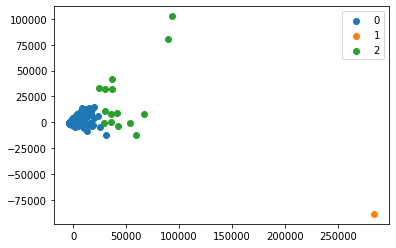

In [109]:
#Getting unique labels
 
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(df_reduced_dim2[label == i , 0] , df_reduced_dim2[label == i , 1] , label = i)
plt.legend()
plt.show()

In [ ]:
#klasifikacija